In [4]:
import os, shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

folder = "../archive/gridsearch/"
features = ["Budget", "Noise", "Alpha", "C", "N-Steps", "LR", "Interactions"]
target = ["Regret", "Std"]

In [5]:
def iterate_files():
    for f in os.listdir(folder):
        run_folder = os.path.join(folder, f)
        result_file = os.path.join(run_folder, "result.txt")
        if os.path.exists(result_file):
            yield result_file
        else:
            print(f"WARNING: no result file in {run_folder}")

In [6]:
def add_attribute(name, default_value):
    for result_file in iterate_files():
        content_lines = []
        with open(result_file) as r_file:
            for line in r_file.readlines():
                if line.startswith(name):
                    print(f"stopping, because {name} was found already in file {result_file}")
                    return
                elif line.startswith(target[0]):
                    content_lines.append(f"{name}: {default_value}\n")
                content_lines.append(f"{line}")
        os.remove(result_file)
        with open(result_file, "w") as f:
            f.writelines(content_lines)

# add_attribute("Interactions", 500000)

In [7]:
result_contents = dict()
for f in features + target:
    result_contents[f] = list()

for result_file in iterate_files():
    with open(result_file) as r_file:
        for line in r_file.readlines():
            if ":" in line:
                parts = line.split(":")
                if parts[0] in features:
                    result_contents[parts[0]].append(float(parts[1]))
                elif parts[0] == target[0]:
                    t_parts = parts[1].split(' +- ')
                    result_contents[target[0]].append(float(t_parts[0]))
                    result_contents[target[1]].append(float(t_parts[1]))

In [8]:
df = pd.DataFrame.from_dict(result_contents)
df

,Budget,Noise,Alpha,C,N-Steps,LR,Interactions,Regret,Std
0,50.0,0.0,0.6,500.0,5.0,0.004,500000.0,0.0090,0.0006
1,50.0,0.5,0.6,500.0,1.0,0.004,500000.0,0.0018,0.0006
2,100.0,0.0,0.6,500.0,2.0,0.004,500000.0,0.0165,0.0003
3,50.0,1.0,0.6,500.0,2.0,0.004,500000.0,0.0090,0.0002
4,50.0,0.2,0.6,500.0,5.0,0.004,500000.0,0.0088,0.0001
5,50.0,0.8,0.6,500.0,1.0,0.004,500000.0,0.0016,0.0003
6,800.0,0.0,0.6,500.0,1.0,0.004,500000.0,0.1249,0.0008
7,50.0,0.8,0.6,500.0,3.0,0.004,500000.0,0.0088,0.0002
8,1600.0,0.0,0.6,500.0,3.0,0.004,500000.0,0.2634,0.0012
9,50.0,0.0,0.6,500.0,2.0,0.004,500000.0,0.0088,0.0001


In [9]:
def plot_boxplot(col_name, df):
    labels = df[col_name].unique()
    labels = sorted(labels)
    #print(labels)
    result = dict()
    for v in labels:
        result[v] = list()
    for index, row in df.iterrows():
        result[row[col_name]].append(row["Regret"])
    values = [result[k] for k in result.keys()]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.boxplot(values)
    ax.set_xlabel(col_name)
    ax.set_ylabel("Regret")
    plt.setp(ax, xticks=range(1, len(labels)+1), xticklabels=labels)
    plt.show()
    plt.clf()

In [10]:
def plot_heatmap(col_name, row_name, df):
    columns = df[col_name].unique()
    columns = sorted(columns)
    columns = [str(c) for c in columns]
    rows = df[row_name].unique()
    rows = sorted(rows)
    rows = [str(r) for r in rows]

    heatmap_df = pd.DataFrame(columns=columns, index=rows, dtype="float")
    divisors_df = heatmap_df.copy(deep=True)
    for rowIndex, row in divisors_df.iterrows():
        for columnIndex, value in row.items():
            heatmap_df.at[rowIndex, columnIndex] = 0.0
            divisors_df.at[rowIndex, columnIndex] = 0.0

    for index, row in df.iterrows():
        heatmap_df.at[str(row[row_name]), str(row[col_name])] += float(row["Regret"])
        divisors_df.at[str(row[row_name]), str(row[col_name])] += 1.0

    for rowIndex, row in heatmap_df.iterrows():
        for columnIndex, value in row.items():
            if divisors_df.at[rowIndex, columnIndex] == 0:
                heatmap_df.at[rowIndex, columnIndex] = np.NAN
            else:
                heatmap_df.at[rowIndex, columnIndex] /= divisors_df.at[rowIndex, columnIndex]

    hm = sns.heatmap(heatmap_df, annot=True)
    hm.set(xlabel=col_name, ylabel=row_name)

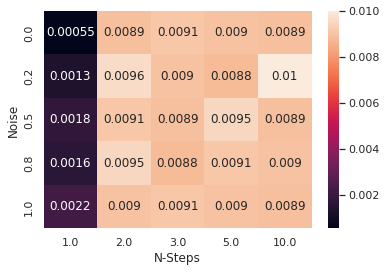

In [11]:
plot_heatmap("N-Steps", "Noise", df[df["Budget"] == 50])

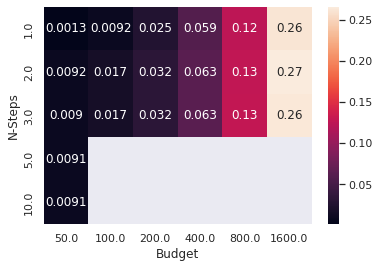

In [12]:
plot_heatmap("Budget", "N-Steps", df)

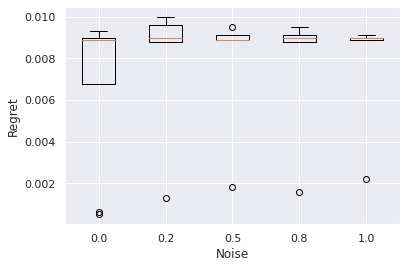

<Figure size 432x288 with 0 Axes>

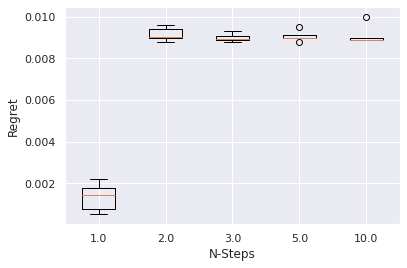

<Figure size 432x288 with 0 Axes>

In [13]:
plot_boxplot("Noise", df[df["Budget"] == 50])
plot_boxplot("N-Steps", df[df["Budget"] == 50])

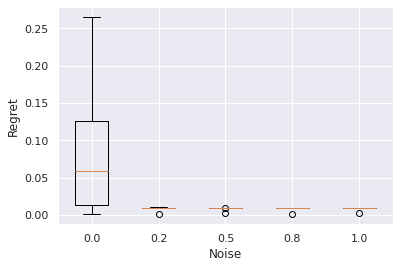

<Figure size 432x288 with 0 Axes>

In [14]:
plot_boxplot("Noise", df)